In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import geopandas as gpd
import statsmodels.formula.api as smf
from plotnine import *
pd.options.mode.chained_assignment = None
energy = pd.read_csv("https://data.cityofnewyork.us/api/views/5zyy-y8am/rows.csv?date=20231212&accessType=DOWNLOAD")
#covered_buildings = pd.read_csv("../data/covered_buildings.csv")

energy['BBL'] = energy['NYC Borough, Block and Lot (BBL)'].str.replace('-', '')
#energy = energy[energy['BBL'].isin(covered_buildings['10 Digit BBL'].astype(str))]

/var/folders/ct/9lwc0fbn26v_v6pz1pfj1dxc0000gq/T/ipykernel_43283/3331911212.py:10: DtypeWarning: Columns (10,78) have mixed types. Specify dtype option on import or set low_memory=False.


In [24]:
colors =  ["#00a5bd", "#e6e6e6", "#f5d855", "#ff8e52", "#000000"]

In [2]:
housing = energy.copy(deep = True)
housing['total_units'] = pd.to_numeric(housing['Multifamily Housing - Total Number of Residential Living Units'], errors='coerce')
housing['co2_intensity'] = pd.to_numeric(housing['Total (Location-Based) GHG Emissions Intensity (kgCO2e/ft²)'], errors='coerce')
housing['EUI'] = pd.to_numeric(housing['Site EUI (kBtu/ft²)'], errors='coerce')
housing['housing_fa'] = pd.to_numeric(housing['Multifamily Housing - Gross Floor Area (ft²)'], errors='coerce')
housing['total_fa'] = pd.to_numeric(housing['Property GFA - Self-Reported (ft²)'], errors='coerce')
housing["total_co2"] = pd.to_numeric(housing['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'], errors='coerce') 
housing["bedrooms"] = pd.to_numeric(housing["Multifamily Housing - Number of Bedrooms"], errors='coerce')
housing["direct_emissions"] =  pd.to_numeric(housing["Direct GHG Emissions (Metric Tons CO2e)"], errors='coerce')
housing["indirect_emissions"] = pd.to_numeric(housing["Indirect (Location-Based) GHG Emissions (Metric Tons CO2e)"], errors='coerce')

In [3]:
housing_trim = housing[['BBL', 'Property Name', 'Property ID', 'total_units', 'EUI', 'bedrooms', 
                        'housing_fa', 'total_fa', 'co2_intensity', "total_co2", 'Latitude', 
                        'Longitude', "Year Built", "Occupancy", "Primary Property Type - Self Selected",
                        "direct_emissions", "indirect_emissions"]].rename(columns={'Property Name': 'name', 'Census Tract' : "GEOID", "Year Built": "year_built", "Primary Property Type - Self Selected" : "property_type"})

housing_trim['total_E'] = housing_trim['EUI'] * housing_trim['total_fa']
housing_trim['avg_apt_size'] = housing_trim['housing_fa'] / housing_trim['total_units']
housing_trim['E_per_apt'] = housing_trim['total_E'] / housing_trim['total_units']
housing_trim['co2_tons_sq'] = housing_trim['co2_intensity'] / 1000
housing_trim['co2_per_apt'] = (housing_trim['co2_tons_sq'] * housing_trim['total_fa']) / housing_trim['total_units']
housing_trim['co2_per_bedroom'] = (housing_trim['co2_tons_sq'] * housing_trim['total_fa']) / housing_trim['bedrooms']
housing_trim['exceeds_2024_limit'] = housing_trim['co2_tons_sq'] > 0.00675
housing_trim['exceeds_2030_limit'] = housing_trim['co2_tons_sq'] > 0.00407
housing_trim['decade_built'] = (np.floor(housing_trim["year_built"]/10)*10).astype(int)
housing_trim['bedrooms_per_apt'] =  housing_trim["bedrooms"] / housing_trim["total_units"]
housing_trim['sqft_per_bedroom'] = housing_trim['housing_fa'] / housing_trim["bedrooms"]
housing_trim["direct_emission_pct"] = housing_trim["direct_emissions"] / housing_trim["total_co2"]

In [4]:
housing_trim["efficiency_quintile"] = pd.qcut(housing_trim["co2_tons_sq"], 5, labels=[1,2,3,4,5])
housing_trim["unit_co2_quintile"] = pd.qcut(housing_trim["co2_per_apt"], 5, labels=[1,2,3,4,5])
housing_trim["bedroom_co2_quintile"] = pd.qcut(housing_trim["co2_per_bedroom"], 5, labels=[1,2,3,4,5])

/Users/canyonfoot/Documents/python_proj/Building-Emissions/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
/Users/canyonfoot/Documents/python_proj/Building-Emissions/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract


In [5]:
coefs = {'Fuel Oil #2 Use (kBtu)' : 0.00007421,
 'Fuel Oil #4 Use (kBtu)' : 0.00007529,
 'District Steam Use (kBtu)' : 0.00004493,
 'Natural Gas Use (kBtu)' : 0.00005311 ,
 'Electricity Use - Grid Purchase (kWh)' : 0.000288962}

In [6]:
housing["Electricity Use - Grid Purchase (kBtu)"]

0                70973
1            1642970.2
2            1395451.2
3            2191128.4
4            3711191.8
             ...      
30480         113651.4
30481         457160.2
30482    Not Available
30483           347345
30484         434965.9
Name: Electricity Use - Grid Purchase (kBtu), Length: 30485, dtype: object

In [7]:
energy_mix = housing[['Property ID', "Primary Property Type - Self Selected"] + list(coefs.keys())]
energy_mix[list(coefs.keys())] = energy_mix[list(coefs.keys())].apply(pd.to_numeric, errors='coerce').fillna(0)

In [8]:
for col, coef in coefs.items():
    energy_mix[col + "_est"] = energy_mix[col] * coef

In [9]:
# Create 'total' column
cols = [col + "_est" for col in coefs.keys()]

energy_mix['total_emissions'] = energy_mix[cols].sum(axis=1)

# Create proportion columns
for col in cols:
    energy_mix[f'{col}_proportion'] = energy_mix[col] / energy_mix['total_emissions']

In [10]:
energy_mix

,Property ID,Primary Property Type - Self Selected,Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Electricity Use - Grid Purchase (kWh),Fuel Oil #2 Use (kBtu)_est,Fuel Oil #4 Use (kBtu)_est,District Steam Use (kBtu)_est,Natural Gas Use (kBtu)_est,Electricity Use - Grid Purchase (kWh)_est,total_emissions,Fuel Oil #2 Use (kBtu)_est_proportion,Fuel Oil #4 Use (kBtu)_est_proportion,District Steam Use (kBtu)_est_proportion,Natural Gas Use (kBtu)_est_proportion,Electricity Use - Grid Purchase (kWh)_est_proportion
0,6414946,Non-Refrigerated Warehouse,0.0,0.0,0.0,449200.0,20801.0,0.000000,0.0,0.0,23.857012,6.010699,29.867711,0.000000,0.0,0.0,0.798756,0.201244
1,9793770,Multifamily Housing,0.0,0.0,0.0,1453700.0,481527.0,0.000000,0.0,0.0,77.206007,139.143005,216.349012,0.000000,0.0,0.0,0.356859,0.643141
2,10177418,Mixed Use Property,0.0,0.0,0.0,849365.4,408983.3,0.000000,0.0,0.0,45.109796,118.180632,163.290429,0.000000,0.0,0.0,0.276255,0.723745
3,13511507,Multifamily Housing,0.0,0.0,0.0,5122899.9,642182.9,0.000000,0.0,0.0,272.077214,185.566455,457.643669,0.000000,0.0,0.0,0.594518,0.405482
4,14009907,Medical Office,16560.0,0.0,0.0,111000.0,1087688.0,1.228918,0.0,0.0,5.895210,314.300500,321.424627,0.003823,0.0,0.0,0.018341,0.977836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30480,6266540,Office,0.0,0.0,0.0,0.0,33309.3,0.000000,0.0,0.0,0.000000,9.625122,9.625122,0.000000,0.0,0.0,0.000000,1.000000
30481,6208838,K-12 School,69013.8,0.0,0.0,1261199.8,133986.0,5.121514,0.0,0.0,66.982321,38.716863,110.820698,0.046214,0.0,0.0,0.604421,0.349365
30482,6798871,Manufacturing/Industrial Plant,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
30483,27001031,Non-Refrigerated Warehouse,0.0,0.0,0.0,1784399.9,101801.0,0.000000,0.0,0.0,94.769479,29.416621,124.186099,0.000000,0.0,0.0,0.763125,0.236875


In [11]:
energy_mix["fuel_oil_emissions"] = energy_mix["Fuel Oil #2 Use (kBtu)_est"] + energy_mix["Fuel Oil #4 Use (kBtu)_est"]
energy_mix["district_steam_emissions"] = energy_mix["District Steam Use (kBtu)_est"]
energy_mix["natural_gas_emissions"] = energy_mix["Natural Gas Use (kBtu)_est"]
energy_mix["electricity_emissions"] = energy_mix["Electricity Use - Grid Purchase (kWh)_est"]

In [15]:
top_20 = energy_mix[["Primary Property Type - Self Selected","fuel_oil_emissions", "district_steam_emissions", "natural_gas_emissions", "electricity_emissions", "total_emissions"]].groupby("Primary Property Type - Self Selected").sum().reset_index().sort_values("electricity_emissions", ascending=False)

In [22]:
top_20['Primary Property Type - Self Selected'] = pd.Categorical(top_20['Primary Property Type - Self Selected'], categories=top_20.sort_values('total_emissions')['Primary Property Type - Self Selected'], ordered=True)

In [13]:
cols = ["fuel_oil_emissions", "district_steam_emissions", "natural_gas_emissions", "electricity_emissions"]
top_20.loc[:, cols] = top_20[cols].div(top_20['total_emissions'], axis=0)

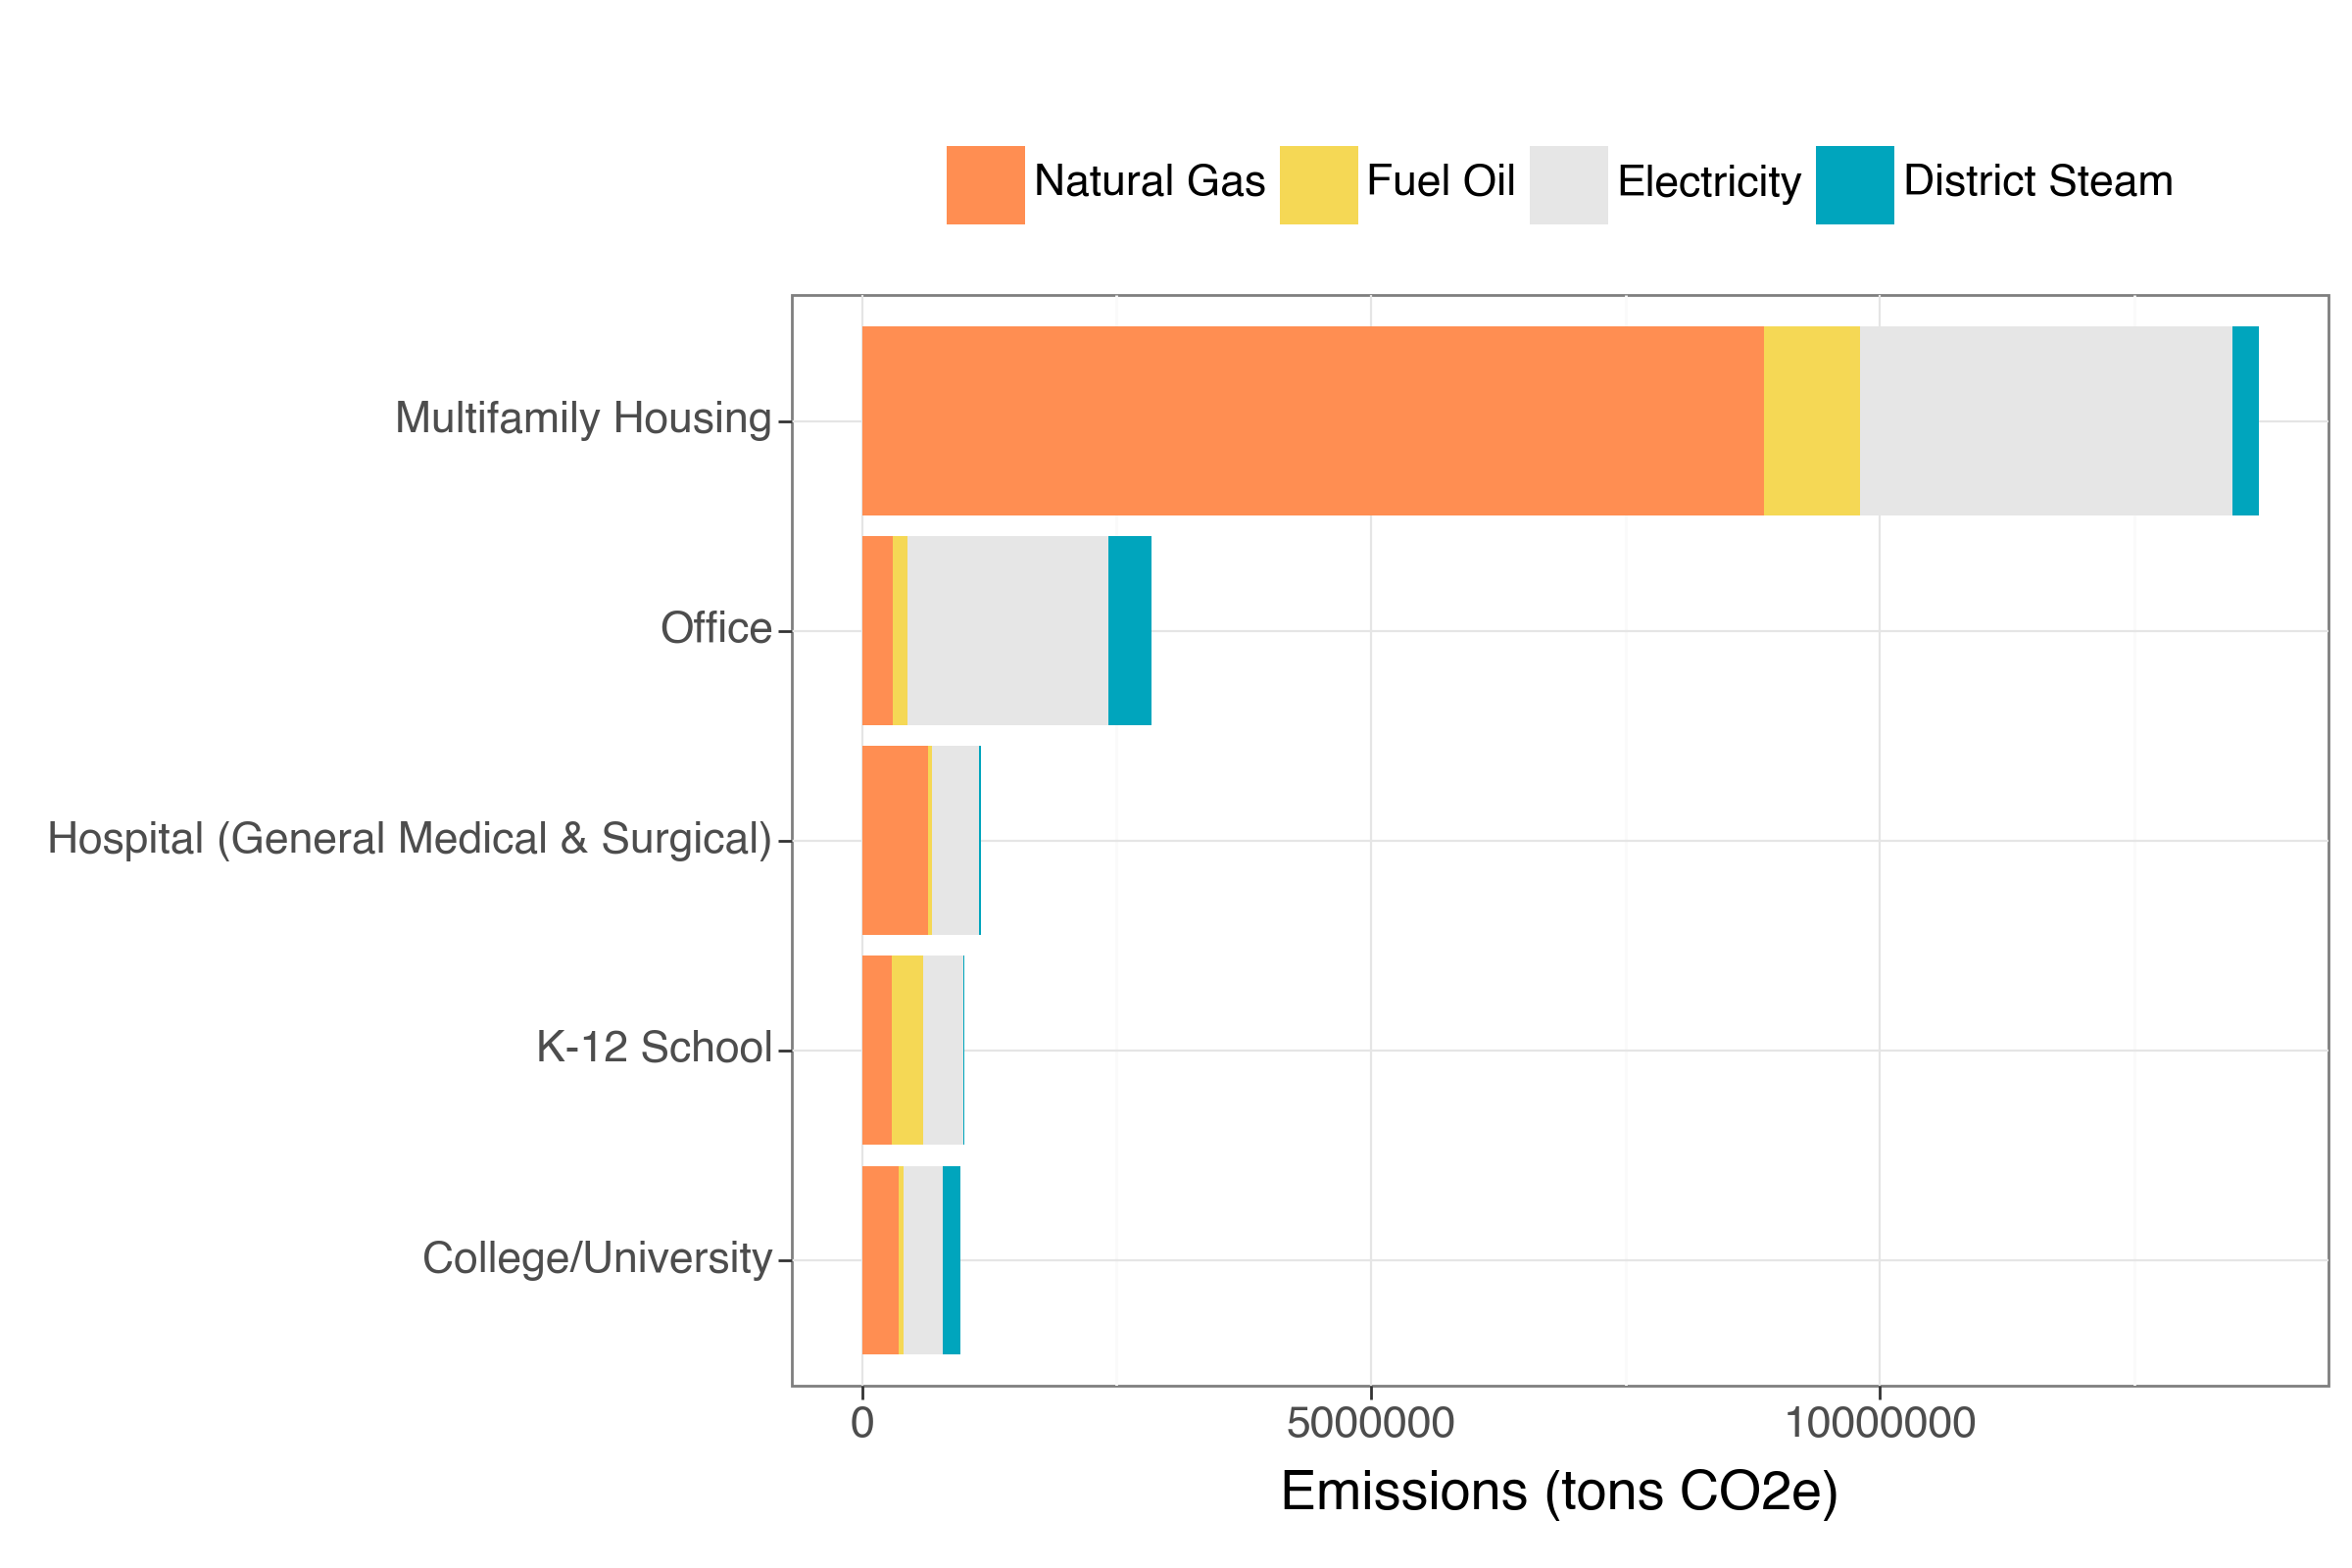

<Figure Size: (1200 x 800)>

In [30]:
from plotnine import guides, guide_legend

plot_dat = top_20.head(5).melt("Primary Property Type - Self Selected").query("variable != 'total_emissions'")

(ggplot(plot_dat, aes(x = "Primary Property Type - Self Selected", y = "value", fill = "variable")) + 
 geom_bar(stat = "identity") +
 coord_flip() + 
 scale_fill_manual(name = " ", values = colors[0:4], labels = ["District Steam", "Electricity", "Fuel Oil", "Natural Gas"]) +
 labs(x = "", y = "Emissions (tons CO2e)") +
 theme_bw(base_size= 20) +
 theme(figure_size=(12,8), legend_position="top") +
 guides(fill=guide_legend(reverse=True)))

In [20]:
plot_dat

,Primary Property Type - Self Selected,variable,value
0,Multifamily Housing,fuel_oil_emissions,9.474033e+05
1,Office,fuel_oil_emissions,1.448924e+05
2,Hospital (General Medical & Surgical),fuel_oil_emissions,3.291195e+04
3,K-12 School,fuel_oil_emissions,3.111760e+05
4,College/University,fuel_oil_emissions,4.169699e+04
5,Multifamily Housing,district_steam_emissions,2.538490e+05
6,Office,district_steam_emissions,4.153142e+05
7,Hospital (General Medical & Surgical),district_steam_emissions,1.668365e+04
8,K-12 School,district_steam_emissions,1.275970e+04
9,College/University,district_steam_emissions,1.775034e+05
